In [5]:
import sys, os
CURRENT_TEST_DIR = os.getcwd()
sys.path.append(CURRENT_TEST_DIR + "/../../../slayerPytorch/src")

In [6]:
import slayerSNN as snn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dtw import dtw, accelerated_dtw
from numpy.linalg import norm
from joblib import Parallel, delayed
import torch
import copy
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split

np.random.seed(1)
torch.manual_seed(1)

In [7]:
X_el = np.load('auxiliaries/electrodes.npy')
X_pac = np.load('auxiliaries/pac.npy')
Y = np.load('auxiliaries/labels.npy')
indices = np.arange(X_el.shape[0])

In [8]:
X_el.shape

(1050, 19, 400)

In [9]:
def get_ohe(_Y):
    target_class = np.zeros([_Y.shape[0], 21])
    for i in range(target_class.shape[0]):
        target_class[i, int(_Y[i])] = 1
    return target_class

In [10]:
X_el = X_el.reshape(X_el.shape[0], X_el.shape[1], 1, 1, X_el.shape[-1])
X_pac = X_pac.reshape(X_pac.shape[0], 1, 1, 1, X_pac.shape[-1])
# Y = Y.reshape(Y.shape[0], Y.shape[1], 1, 1, Y.shape[-1])

In [11]:
X_el_train, X_el_test, y_train, y_test, indx_train, indx_test = train_test_split(X_el, Y, indices, test_size=0.30, random_state=42, stratify=Y)

In [12]:
X_el_train = torch.FloatTensor(X_el_train)
y_train = torch.FloatTensor(y_train)
target_class_train = torch.FloatTensor(get_ohe(y_train).reshape(-1, 21, 1, 1, 1))
    
X_el_test = torch.FloatTensor(X_el_test)
y_test = torch.FloatTensor(y_test)
target_class_test= torch.FloatTensor(get_ohe(y_test).reshape(-1, 21, 1, 1, 1))

X_pac_train = torch.FloatTensor(X_pac[indx_train])
X_pac_test = torch.FloatTensor(X_pac[indx_test])

X_el_train.shape, y_train.shape, target_class_train.shape, X_pac_train.shape, X_pac_test.shape

(torch.Size([735, 19, 1, 1, 400]),
 torch.Size([735]),
 torch.Size([735, 21, 1, 1, 1]),
 torch.Size([735, 1, 1, 1, 8800]),
 torch.Size([315, 1, 1, 1, 8800]))

In [13]:
# %time
# m,n = X_el[0,:].squeeze().shape
# out = np.zeros((m,22*n),dtype=X_el.dtype)
# out[:,::22] = X_el[0,:].squeeze()

In [14]:
params1 = {
    "neuron": {
        "type": "SRMALPHA",
        "theta": 10, # 10
        "tauSr": 10.0,
        "tauRef": 1.0,
        "scaleRef": 2,
        "tauRho": 1,
        "scaleRho": 1,
    },
    "simulation": {"Ts": 1.0, "tSample": 400, "nSample": 1},
}

params2 = {
    "neuron": {
        "type": "SRMALPHA",
        "theta": 10, # 10
        "tauSr": 10.0,
        "tauRef": 1.0,
        "scaleRef": 2,
        "tauRho": 1,
        "scaleRho": 1,
    },
    "simulation": {"Ts": 1.0, "tSample": 8800, "nSample": 1},
    "training": {
        "error": {
            "type": "NumSpikes",  # "NumSpikes" or "ProbSpikes"
            "probSlidingWin": 20,  # only valid for ProbSpikes
            "tgtSpikeRegion": {  # valid for NumSpikes and ProbSpikes
                "start": 0,
                "stop": 8800,
            },
            "tgtSpikeCount": {True: 5000, False: 20},
        }
    },
}


In [15]:
train_dataset = torch.utils.data.TensorDataset(X_el_train, X_pac_train, target_class_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset,shuffle=True,batch_size=8)

test_dataset = torch.utils.data.TensorDataset(X_el_test, X_pac_test, target_class_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset,shuffle=True,batch_size=8)

In [20]:
class SlayerMLP(torch.nn.Module):
    def __init__(self, params1, params2, input_size, hidden_size1,hidden_size2, output_size):
        super(SlayerMLP, self).__init__()
        self.output_size = output_size
        self.slayer1 = snn.layer(params1["neuron"], params1["simulation"])
        self.slayer2 = snn.layer(params2["neuron"], params2["simulation"])
        self.fc1 = self.slayer1.dense(input_size, hidden_size1)
        self.fc2 = self.slayer1.dense(hidden_size1, hidden_size2)
        self.fc3 = self.slayer2.dense(hidden_size2+1, output_size)

    def forward(self, spike_input_el, spike_input_pac):
        
        # el data
        spike_el_1 = self.slayer1.spike(self.fc1(spike_input_el))
        spike_el_2 = self.slayer1.spike(self.slayer1.psp(self.fc2(spike_el_1)))
        
        # impute with zero
        imputed_el = torch.zeros((spike_el_2.shape[0],spike_el_2.shape[1], 1,1,spike_el_2.shape[-1]*22))
        imputed_el[...,::22] = spike_el_2
        imputed_el = imputed_el.to(device)

        # pac to spike
        spike_pac_1 = self.slayer2.spike(spike_input_pac)
        # merge with pac
        merged_data = torch.cat([imputed_el, spike_pac_1], 1)
        
        spike_output = self.slayer2.spike(self.slayer2.psp(self.fc3(merged_data)))
        return spike_output

In [21]:
device = torch.device("cuda:1")
net = SlayerMLP(params1,params2, 19, 64, 32, 21).to(device)

In [22]:
error = snn.loss(params2).to(device)
optimizer = torch.optim.RMSprop(net.parameters(), lr=0.001, weight_decay=0.5)

In [23]:
148/len(train_dataset)

0.20136054421768707

In [29]:
train_losses=[]
train_accs = []
test_losses = []
test_accs = []
for epoch in range(301):
    net.train()
    correct = 0
    num_samples = 0
    loss_train = 0
    for i, (tact_el, tact_pac, target, label) in enumerate(train_loader):
        
        tact_el = tact_el.to(device)
        tact_pac = tact_pac.to(device)
        target = target.to(device)
        
        output = net.forward(tact_el, tact_pac)
        correct += torch.sum(snn.predict.getClass(output) == label).data.item()
        num_samples += len(label)
        loss = error.numSpikes(output, target)
        loss_train += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
                
    if epoch%10 == 0:
        print('Epoch: ', epoch, ' --------------------------')
        print('Train loss:', loss_train/len(train_dataset))
        print('Train accuracy:', correct/len(train_dataset))
    train_accs.append(correct/len(train_dataset))
    train_losses.append(loss_train/len(train_dataset))
        
    net.eval()
    correct = 0
    num_samples = 0
    loss_test = 0
    with torch.no_grad():
        for i, (tact_el, tact_pac, target, label) in enumerate(test_loader):

            tact_el = tact_el.to(device)
            tact_pac = tact_pac.to(device)

            output = net.forward(tact_el, tact_pac)
            correct += torch.sum(snn.predict.getClass(output) == label).data.item()
            num_samples += len(label)
            loss = error.numSpikes(output, target)
            loss_test += loss.item()
            
    if epoch%1 == 0:
        print('Test loss:', loss_test/len(test_dataset))
        print('Test accuracy:', correct/len(test_dataset))
    test_accs.append(correct/len(test_dataset))
    test_losses.append(loss_test/len(test_dataset))

Epoch:  0  --------------------------
Train loss: 291.7345605966996
Train accuracy: 0.9414965986394558
Test loss: 306.3567388625372
Test accuracy: 0.9523809523809523
Test loss: 306.0325501941499
Test accuracy: 0.946031746031746
Test loss: 304.44876805865573
Test accuracy: 0.9492063492063492
Test loss: 303.98451528397817
Test accuracy: 0.9428571428571428
Test loss: 303.6070467509921
Test accuracy: 0.946031746031746
Test loss: 302.94063178168403
Test accuracy: 0.946031746031746
Test loss: 303.6821971106151
Test accuracy: 0.9492063492063492
Test loss: 302.94000437903026
Test accuracy: 0.9428571428571428
Test loss: 301.08966568235365
Test accuracy: 0.9523809523809523
Test loss: 299.7003985692584
Test accuracy: 0.946031746031746
Epoch:  10  --------------------------
Train loss: 284.5102120535714
Train accuracy: 0.9401360544217687
Test loss: 298.2192092168899
Test accuracy: 0.9492063492063492
Test loss: 301.9985291496156
Test accuracy: 0.9428571428571428
Test loss: 299.52625746954055
Test a

Test loss: 249.12819204179067
Test accuracy: 0.946031746031746
Test loss: 248.5107129293775
Test accuracy: 0.946031746031746
Test loss: 249.15387219625805
Test accuracy: 0.9492063492063492
Test loss: 247.40520881773932
Test accuracy: 0.9428571428571428
Test loss: 245.7633534264943
Test accuracy: 0.9428571428571428
Test loss: 246.40152762276784
Test accuracy: 0.9428571428571428
Test loss: 247.4793414403522
Test accuracy: 0.9492063492063492
Test loss: 246.75543658544146
Test accuracy: 0.9492063492063492
Test loss: 246.6944361126612
Test accuracy: 0.946031746031746
Test loss: 245.54657263377356
Test accuracy: 0.946031746031746
Epoch:  120  --------------------------
Train loss: 220.0569502434763
Train accuracy: 0.9551020408163265
Test loss: 245.00309477306547
Test accuracy: 0.946031746031746
Test loss: 245.68221212720115
Test accuracy: 0.9523809523809523
Test loss: 242.7121829078311
Test accuracy: 0.9492063492063492
Test loss: 244.31011972578744
Test accuracy: 0.9523809523809523
Test loss

KeyboardInterrupt: 

In [30]:
tact_el.shape

torch.Size([8, 19, 1, 1, 400])

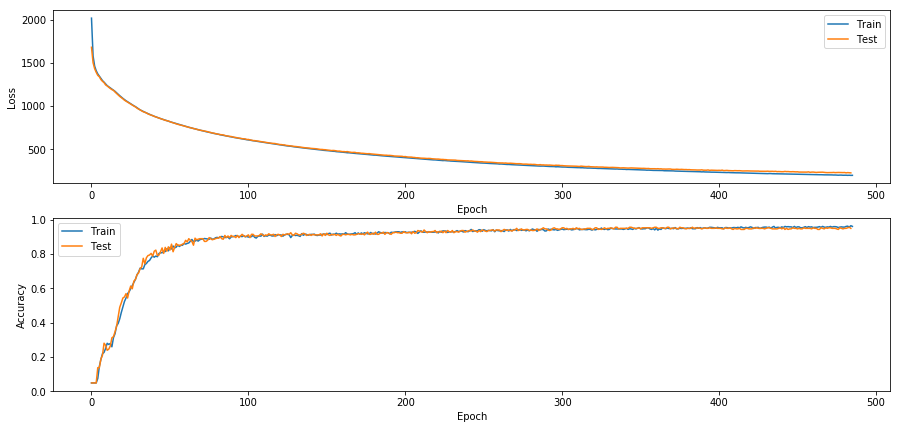

In [31]:
fig, ax = plt.subplots(2, figsize=(15,7))

ax[0].plot(train_losses)
ax[0].plot(test_losses)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend(['Train', 'Test'])

ax[1].plot(train_accs)
ax[1].plot(test_accs)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend(['Train', 'Test'])

plt.show()

In [32]:
np.max(test_accs)

0.9555555555555556

In [33]:
np.max(train_accs)

0.964625850340136